In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append('utils/')

import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# use non standard flow_from_directory
from image_preprocessing_ver2 import ImageDataGenerator
# it outputs y_batch that contains onehot targets and logits
# logits came from xception

from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K

from mobilenet import get_mobilenet
from keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
data_dir = '/home/ubuntu/data/'

In [4]:
train_logits = np.load(data_dir + 'train_logits.npy')[()]
val_logits = np.load(data_dir + 'val_logits.npy')[()]

In [5]:
data_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

# note: i'm also passing dicts of logits
train_generator = data_generator.flow_from_directory(
    data_dir + 'train', train_logits,
    target_size=(224, 224),
    batch_size=64
)

val_generator = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(224, 224),
    batch_size=64
)

Found 25600 images belonging to 256 classes.
Found 5120 images belonging to 256 classes.


# Create model

In [6]:
temperature = 5.0

In [7]:
model = get_mobilenet(224, alpha=0.25, weight_decay=1e-5, dropout=0.1)

# remove softmax
model.layers.pop()

# usual probabilities
logits = model.layers[-1].output
probabilities = Activation('softmax')(logits)

# softed probabilities
logits_T = Lambda(lambda x: x/temperature)(logits)
probabilities_T = Activation('softmax')(logits_T)

output = concatenate([probabilities, probabilities_T])
model = Model(model.input, output)
# now model outputs 512 dimensional vectors

# Create custom loss

In [8]:
def knowledge_distillation_loss(y_true, y_pred, lambda_const):    
    
    # split in 
    #    onehot hard true targets
    #    logits from xception
    y_true, logits = y_true[:, :256], y_true[:, 256:]
    
    # convert logits to soft targets
    y_soft = K.softmax(logits/temperature)
    
    # split in 
    #    usual output probabilities
    #    probabilities made softer with temperature
    y_pred, y_pred_soft = y_pred[:, :256], y_pred[:, 256:]    
    
    return lambda_const*logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)

# For testing use usual output probabilities (without temperature)

In [9]:
def accuracy(y_true, y_pred):
    y_true = y_true[:, :256]
    y_pred = y_pred[:, :256]
    return categorical_accuracy(y_true, y_pred)

In [10]:
def top_5_accuracy(y_true, y_pred):
    y_true = y_true[:, :256]
    y_pred = y_pred[:, :256]
    return top_k_categorical_accuracy(y_true, y_pred)

In [11]:
def categorical_crossentropy(y_true, y_pred):
    y_true = y_true[:, :256]
    y_pred = y_pred[:, :256]
    return logloss(y_true, y_pred)

In [12]:
# logloss with only soft probabilities and targets
def soft_logloss(y_true, y_pred):     
    logits = y_true[:, 256:]
    y_soft = K.softmax(logits/temperature)
    y_pred_soft = y_pred[:, 256:]    
    return logloss(y_soft, y_pred_soft)

# Train

In [13]:
lambda_const = 0.07

model.compile(
    optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True), 
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, lambda_const), 
    metrics=[accuracy, top_5_accuracy, categorical_crossentropy, soft_logloss]
)

In [14]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.01), 
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

Epoch 1/30
400/400 [==============================] - 24s - loss: 5.8086 - accuracy: 0.2173 - top_5_accuracy: 0.4171 - categorical_crossentropy: 4.0499 - soft_logloss: 5.5225 - val_loss: 5.6917 - val_accuracy: 0.4475 - val_top_5_accuracy: 0.7285 - val_categorical_crossentropy: 2.6774 - val_soft_logloss: 5.5013
Epoch 2/30
400/400 [==============================] - 23s - loss: 5.6726 - accuracy: 0.4953 - top_5_accuracy: 0.7514 - categorical_crossentropy: 2.4414 - soft_logloss: 5.4984 - val_loss: 5.6416 - val_accuracy: 0.5660 - val_top_5_accuracy: 0.8070 - val_categorical_crossentropy: 2.0523 - val_soft_logloss: 5.4944
Epoch 3/30
400/400 [==============================] - 24s - loss: 5.6378 - accuracy: 0.5785 - top_5_accuracy: 0.8072 - categorical_crossentropy: 2.0036 - soft_logloss: 5.4938 - val_loss: 5.6240 - val_accuracy: 0.5951 - val_top_5_accuracy: 0.8303 - val_categorical_crossentropy: 1.8349 - val_soft_logloss: 5.4916
Epoch 4/30
400/400 [==============================] - 23s - loss

# Loss/epoch plots

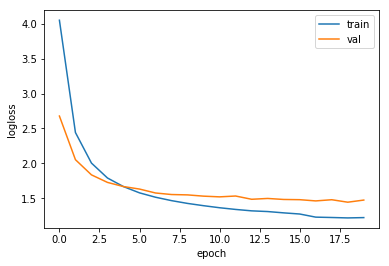

In [15]:
plt.plot(model.history.history['categorical_crossentropy'], label='train');
plt.plot(model.history.history['val_categorical_crossentropy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');

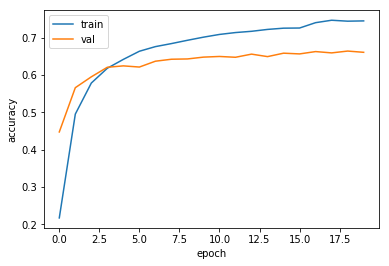

In [16]:
plt.plot(model.history.history['accuracy'], label='train');
plt.plot(model.history.history['val_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

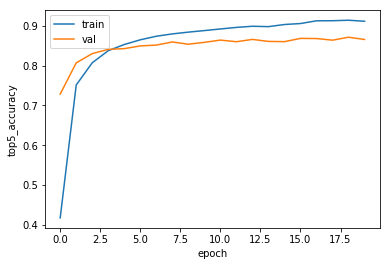

In [17]:
plt.plot(model.history.history['top_5_accuracy'], label='train');
plt.plot(model.history.history['val_top_5_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Results

In [18]:
val_generator_no_shuffle = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(224, 224),
    batch_size=64, shuffle=False
)

Found 5120 images belonging to 256 classes.


In [19]:
print(model.evaluate_generator(val_generator_no_shuffle, 80))

[5.595249432325363, 0.66171875000000002, 0.86679687500000002, 1.4644993908703328, 5.4862456738948824]
